In [1]:
from llm_from_papers.models import GPT2Model
import torch
import tiktoken

In [2]:
config = {
    "vocab_size": 50257,
    "context_size": 256,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 12,
    "dropout": 0.1,
    "qkv_bias": False,
}

torch.manual_seed(42)
model = GPT2Model(config)
model.eval()

GPT2Model(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (dropout_embed): Dropout(p=0.1, inplace=False)
  (transfomer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAtt

In [3]:
def genrate_simple_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # (bz, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (bz, vocab_size)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bz, 1)
        idx = torch.cat((idx, idx_next), dim=1)  # (bz
    return idx

In [4]:
def text_to_tokens(text, enc):
    tokens = enc.encode(text, allowed_special={"<|endoftext|>"})
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(0)  # (1, seq_len)

def tokens_to_text(tokens, enc):
    tokens = tokens.squeeze().tolist()
    return enc.decode(tokens)

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

tokens = genrate_simple_text(
    model,
    text_to_tokens(start_context, tokenizer),
    max_new_tokens=10,
    context_size=config["context_size"],
)

print(tokens_to_text(tokens, tokenizer))

Every effort moves youodonuyomiassin Basic batted JavierPandottestriver Pearce


In [5]:
input1 = "every effort moves"
input2 = "I really like"

inputs = torch.tensor([
    text_to_tokens(input1, tokenizer).squeeze().tolist(),
    text_to_tokens(input2, tokenizer).squeeze().tolist(),
], dtype=torch.long)  # (2, seq_len )

inputs

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

In [6]:
target1 = " effort moves you"
target2 = " really like chocolate"

targets = torch.tensor([
    text_to_tokens(target1, tokenizer).squeeze().tolist(),
    text_to_tokens(target2, tokenizer).squeeze().tolist(),
], dtype=torch.long)  # (2, seq_len )

targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [7]:
with torch.no_grad():
    logits = model(inputs)  # (bz, seq_len, vocab_size)
probas = torch.softmax(logits, dim=-1)  # (bz, seq_len, vocab_size)
probas.shape

torch.Size([2, 3, 50257])

In [8]:
tokens_ids = torch.argmax(probas, dim=-1)  # (bz, seq_len)
tokens_ids

tensor([[24851,   406, 40115],
        [29716, 40825, 19647]])

In [9]:

print(f"Target batch 1: {tokens_to_text(targets[0:1], tokenizer)}")
print(f"Predicted batch 1: {tokens_to_text(tokens_ids[0:1], tokenizer)}")

print(f"Target batch 2: {tokens_to_text(targets[1:2], tokenizer)}")
print(f"Predicted batch 2: {tokens_to_text(tokens_ids[1:2], tokenizer)}")

Target batch 1:  effort moves you
Predicted batch 1: etti L HO
Target batch 2:  really like chocolate
Predicted batch 2: ovskySounds energ


In [10]:
from pathlib import Path

file_path = Path("../data/the-verdict.txt")
with file_path.open("r") as f:
    text_data = f.read()

print(f"Length of text data: {len(text_data)} characters")

total_tokens = text_to_tokens(text_data, tokenizer)
print(f"Total tokens in text data: {total_tokens.shape[1]} tokens")

Length of text data: 20479 characters
Total tokens in text data: 5145 tokens


In [11]:
from llm_from_papers.datasets import GPTDatasetV1

train_ration = 0.9
split_idx = int(len(text_data) * train_ration)
train_txt = text_data[:split_idx]
val_txt = text_data[split_idx:]



In [12]:
torch.manual_seed(123)
train_dataset = GPTDatasetV1(train_txt, tokenizer=tokenizer, max_length=config["context_size"], stride=config["context_size"])
val_dataset = GPTDatasetV1(val_txt, tokenizer=tokenizer, max_length=config["context_size"], stride=config["context_size"])

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)



In [13]:
print("Train loader")

for x, y in train_dataloader:
    print(x.shape, y.shape)
    
print("Validation loader")
for x, y in val_dataloader:
    print(x.shape, y.shape)


Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [14]:
def compute_loss(input_batch, target_batch, model, device):
    input_batch = input_batch.long().to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)  # (bz, seq_len, vocab_size)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

def compute_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else :
        num_batches = min(num_batches, len(data_loader))
    for i, (x, y) in enumerate(data_loader):
        if i < num_batches:
            loss = compute_loss(x, y, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
    


In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [16]:
model.to(device)
with torch.no_grad():
    train_loss = compute_loss_loader(train_dataloader, model, device, num_batches=10)
    val_loss = compute_loss_loader(val_dataloader, model, device, num_batches=10)
print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 11.0040, Val loss: 11.0441


In [17]:
from tqdm.auto import tqdm

def train_model_simple(model, train_dataloader, val_dataloader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tockens_seens = [], [], []
    token_seens, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            loss = compute_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seens += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = compute_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
                    val_loss = compute_loss_loader(val_dataloader, model, device, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tockens_seens.append(token_seens)
                print(f"Epoch {epoch}, step {global_step}, tokens seen {token_seens}, train loss {train_loss:.4f}, val loss {val_loss:.4f}")

                # Generate text
                tokens = genrate_simple_text(
                    model,
                    text_to_tokens(start_context, tokenizer).to(device),
                    max_new_tokens=20,
                    context_size=config["context_size"],
                )
                print(f"Generated text: {tokens_to_text(tokens.cpu(), tokenizer)}")

                model.train()
    return train_losses, val_losses, track_tockens_seens



In [18]:
from torch.optim import AdamW

torch.manual_seed(42)

model = GPT2Model(config)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-4, weight_decay=1e-1)

num_epochs = 10

train_losses, val_losses, tokens_seens = train_model_simple(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0, step 0, tokens seen 512, train loss 9.9808, val loss 10.0307
Generated text: Every effort moves you, of of of the the, of of the,, of the of of of of the the
Epoch 0, step 5, tokens seen 3072, train loss 8.0791, val loss 8.3658
Generated text: Every effort moves you, the the the the the the the the the, the the the the the.





  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1, step 10, tokens seen 5632, train loss 6.7471, val loss 7.1183
Generated text: Every effort moves you,,,,,,,,,,,, the,,,,,, the
Epoch 1, step 15, tokens seen 8192, train loss 6.0328, val loss 6.6425
Generated text: Every effort moves you.





















  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2, step 20, tokens seen 10752, train loss 6.1322, val loss 7.4231
Generated text: Every effort moves you




















Epoch 2, step 25, tokens seen 13312, train loss 5.4557, val loss 6.4470
Generated text: Every effort moves you, I had to the, and, and, and, and, and of the of the a


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3, step 30, tokens seen 15872, train loss 5.0813, val loss 6.5915
Generated text: Every effort moves you, I was to have, and he was, and I had been






Epoch 3, step 35, tokens seen 18432, train loss 4.7824, val loss 6.4009
Generated text: Every effort moves you, I was the--I, I had the, and I had been
"I, I


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4, step 40, tokens seen 20992, train loss 4.6790, val loss 6.4017
Generated text: Every effort moves you a





















  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5, step 45, tokens seen 23552, train loss 3.9282, val loss 6.3925
Generated text: Every effort moves you, I was not that, I had been--I, the picture.





Epoch 5, step 50, tokens seen 26112, train loss 3.3854, val loss 6.3643
Generated text: Every effort moves you.








"--as the last he had been his pictures


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6, step 55, tokens seen 28672, train loss 2.9145, val loss 6.3371
Generated text: Every effort moves you know," was not that, and he was not to have my dear of the house when she began
Epoch 6, step 60, tokens seen 31232, train loss 2.5885, val loss 6.2949
Generated text: Every effort moves you in the picture to see it was dead."













  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7, step 65, tokens seen 33792, train loss 2.1235, val loss 6.3021
Generated text: Every effort moves you in the picture.





"I had the last him. Gisburn
Epoch 7, step 70, tokens seen 36352, train loss 1.6268, val loss 6.3056
Generated text: Every effort moves you in the inevitable.


"I felt him down across the last him.





  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8, step 75, tokens seen 38912, train loss 1.3054, val loss 6.4064
Generated text: Every effort moves you?"





"I felt him down across the last him back to my work
Epoch 8, step 80, tokens seen 41472, train loss 1.0098, val loss 6.4149
Generated text: Every effort moves you?"




"--I felt him--as his last word.





  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9, step 85, tokens seen 44032, train loss 0.7832, val loss 6.4999
Generated text: Every effort moves you?"

"Yes--as, his pictures--so handsome, so charming, when she began


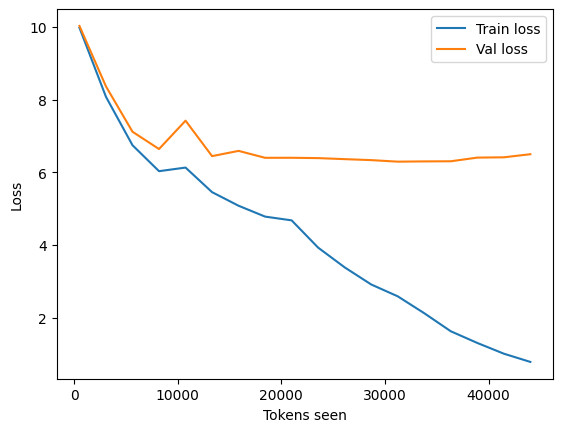

In [19]:
import matplotlib.pyplot as plt
plt.plot(tokens_seens, train_losses, label="Train loss")
plt.plot(tokens_seens, val_losses, label="Val loss")
plt.xlabel("Tokens seen")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Exploring sampling techniques

For now, we generate text using the most probable token. But as our network it determinist, it means that we are always getting the same output for each generation run. 

Here, we are going to explore a few techniques to overcome this issue :

## 1. Temperature scaling  

The temperature parameter is used to control the randomness of predictions by scaling the logits before applying the softmax function. A higher temperature value increases randomness, while a lower value makes the model more confident and deterministic.

In [20]:
def sample(logits):
    return torch.multinomial(logits, num_samples=1).item()

In [21]:
def sofmax_with_temp(logits, temperature=1.0):
    if temperature <= 0:
        raise ValueError("Temperature must be greater than 0")
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

In [22]:
from llm_from_papers.utils import sample

tokens_ids = sample(model=model, idx=text_to_tokens("Every effort moves you", tokenizer).to(device), max_new_tokens=20, context_length=config["context_size"], temperature=1.5, top_k=50)

print(tokens_to_text(tokens_ids, tokenizer))


Every effort moves you just; so gen and."For had been through, seen which werethat how by eyes picture--


In [ ]:
# save my nice model

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "gpt2_model.pth")